# Generative Adversarial Networks with Keras (Work In Progress)



Do you remember how do we generate random values starting from a uniformely distributed random variable $U$? We can do that using the inverse transform techinique, which states that $X=F^{-1}(U)$ is a random variable with [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) (CDF) given by $F_X(X) = F$.

For example, assume we want to generate an exponentialy distributed random variable. Wikipedia gives us the following facts:
1. Probability disbutition function (PDF):
\begin{equation}
f_X(x) = \lambda e^{-\lambda x}
\end{equation}
2. CDF:
\begin{equation}
F_X(x) = \int_{-inf}^x f_X(z)dz = 1-e^{-\lambda x}
\end{equation}
3. Inverting that CDF we have:
\begin{equation}
F_X^{-1}(u) = -\frac{1}{\lambda}log(1-u)
\end{equation}

Let's check that with numpy

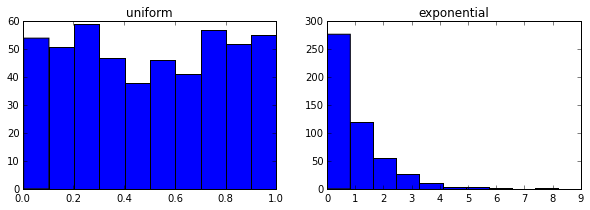

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
l = 1 # lambda
u = np.random.uniform(0, 1, (500,))
e = -np.log(1-u) / l

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.hist(u)
plt.title('uniform')

plt.subplot(122)
plt.hist(e)
_ = plt.title('exponential')

Cool! But what if we want to generate pictures like those in the MNIST dataset? Can we estimate something like and inverse CDF in that case? Well, it happens that this is a hard problem and it has an entire field dedicated to it. That field is called Generative Modelling by the machine learning community. If you remember Restricted Boltzman Machines (RBM), Autoencoders (AE), Sparse Coding, etc, that's what I'm talking about. Here we are interested in a generative model proposed by Goodfellow et. al [1] called Generative Adversarial Networks (GAN).

GANs propose to generate samples from a dataset using (guess what?) adaptive neural networks. Thus, given ac uniformely distributed vector $\mathbf{U}$, the generated samples are given by $\mathbf{X} = G(\mathbf{U})$. Which doesn't quite solve the problem before we define how to train the DNN $G(\cdot)$. Let us think about that next, following Goodfellow et. al [1].

Given a dataset $S$, and a test statistic $D(\cdot)$, we say that a sample $\mathbf{X}$ comes from the underlying PDF that generated the samples in $S$ if $D(\mathbf{X}) = 1$. We reject that hypothesis if $D(\mathbf{X}) = 0$. I would give you a dollar if you can guess how the guys from Bengio's lab proposed to parameterize $D(\cdot)$... 

WRONG! They used DNNs. 

As a note, their derivations are general enough, and we can use other adaptive models instead. That being said, if $G$ wants to be good enough it must pass the test defined by $D$. On the other hand, $D$ must play it hard and only pass the real samples coming from $S$ itself. This way one can define a min-max game where the cost function for $G$ is the binary crossentropy between $D(G(\mathbf{U}))$ and 1, i.e

\begin{equation}
\mathcal{L}_G = log(D(G(\mathbf{U}))),
\end{equation}

the cost function for $D$, on the other hand, is

\begin{equation}
\mathcal{L}_D = \begin{cases}
        \begin{array}{lcl}
        log(D(\mathbf{X})), \quad\quad if: \mathbf{X}\in S \\
        log(1 - D(\mathbf{X})), \quad if: \mathbf{X}=G(\mathbf{U}).
        \end{array}
\end{cases}
\end{equation}

Note that the final solution (minimum for the combined cost functions above) should give us realistic looking samples $G(\mathbf{U})$ and a totally clueless $D$ returning $D(X) = \frac{1}{2}$. Hopefully we understood that well enough to hack something up with Keras. Let us do that for the MNIST dataset.

In [ ]:
# These first lines are a copy paste from keras/examples/mnist_mlp.py
%matplotlib inline

from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import theano
np.random.seed(1337)  # for reproducibility

from copy import copy, deepcopy

from keras.datasets import mnist
from keras.models import Sequential, Graph
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils, generic_utils
from keras.objectives import binary_crossentropy
from keras.callbacks import Callback
from keras.layers.advanced_activations import LeakyReLU as lrelu
from keras.layers.convolutional import Convolution2D, MaxPooling2D

batch_size = 128
nb_classes = 10
nb_epoch = 20

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

First we define our model for $D$.

In [ ]:
dim = 3000  # dim of the random number vector
mnist_dim = 784

detector = Sequential()
detector.add(Dense(dim, input_dim=mnist_dim))
detector.add(lrelu())
detector.add(Dropout(.3))
detector.add(Dense(dim))
detector.add(Activation('tanh'))
detector.add(Dropout(.3))
detector.add(Dense(1)) # 1: Yes, it belongs to S, 0: fake!
detector.add(Activation('sigmoid'))


Next, we make a copy of $D$ that we should use to adapt the cost function for $G$. Note that this copy should not be adapted with gradients coming from $\mathcal{L}_G$, otherwise $D$ will be cheating and we won't learn anything useful. To do that with Keras, we simply set `trainable=False`.

Finally we can define $G$ using our hacked detector.

In [ ]:
# Fully Connected model

sampler = Sequential()
sampler.add(Dense(dim, input_dim=dim))
sampler.add(lrelu())
sampler.add(Dense(dim))
sampler.add(lrelu())
sampler.add(Dense(mnist_dim))
sampler.add(Activation('sigmoid'))

# This is G itself!!!
sample_fake = theano.function([sampler.get_input()], sampler.get_output())

# We add the detector G on top, but it won't be adapted with this cost function.
# But here is a dirty hack: Theano shared variables on the GPU are the same for 
# `detector` and `detector_no_grad`, so, when we adapt `detector` the values of 
# `detector_no_grad` will be updated as well. But this only happens following the 
# correct gradients. 
# Don't you love pointers? Aliasing can be our friend sometimes.
detector.trainable = False
sampler.add(detector)

opt_g = Adam(lr=.001) # I got better results when 
                      # detector's learning rate is faster
sampler.compile(loss='binary_crossentropy', optimizer=opt_g)

In [ ]:
# debug
opt_d = Adam(lr=.002)
detector.trainable = True
detector.compile(loss='binary_crossentropy', optimizer=opt_d)
detector.predict(np.ones((3, mnist_dim))).shape

Here is how we can train our networks. First we sample a uniform random vector $\mathbf{U}$, using that we sample fake images with $G(\mathbf{U})$. We train $G$ to get passing values in the $D$ test, I mean 1. Later, we concatenate the fake images with some real MNIST images and train $D$ to return zeros for the formers and ones for the later.

In [ ]:
nb_epoch = 1000 # it takes some time to get something recognizable.
batch_size = 128
num_batches = X_train.shape[0] / 128
fig = plt.figure()
fixed_noise = np.random.uniform(-1, 1, (9, dim)).astype('float32') # Let us visualize how these sampes evolve with training

progbar = generic_utils.Progbar(1000)
try:
    for e in range(nb_epoch):
        loss0 = 0
        loss1 = 0

        for (first, last) in zip(range(0, X_train.shape[0]-batch_size, batch_size),
                                 range(batch_size, X_train.shape[0], batch_size)):
            noise_batch = np.random.uniform(-1, 1, (batch_size, dim)).astype('float32')
            fake_samples = sample_fake(noise_batch)
            true_n_fake = np.concatenate([X_train[first: last],
                                          fake_samples], axis=0)
            y_batch = np.concatenate([np.ones((batch_size, 1)),
                                      np.zeros((batch_size, 1))], axis=0).astype('float32')
            all_fake = np.ones((batch_size, 1)).astype('float32')
            # We take turns adapting G and D. We may give D an upper hand,
            #  letting it train for more turns, keeping G fixed.
            #  Do that increasing the upper hand `uh` variable.
            uh = 2
            if e % uh == 0:
                loss0 += sampler.train_on_batch(noise_batch, all_fake)[0]
            else:
                loss1 += detector.train_on_batch(true_n_fake, y_batch)[0]
            loss = loss0 + loss1

        progbar.add(1, values=[("train loss", loss),
                               ("G loss", loss0),
                               ("D loss", loss1)])

        if e % 10 == 0: # visualize results once in a while
            fixed_fake = sample_fake(fixed_noise)
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                plt.imshow(fixed_fake[i].reshape((28,28)), cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
            plt.savefig(str(e)+'.png')
except:
    pass

# Convolutional GAN

As an easy exercise for the reader (best way to look knowledgeable when your lecture notes aren't finished yet), I recommend you to modify this code to parameterize $G$ and $D$ as convolutional networks. Check [DCGAN](https://github.com/Newmu/dcgan_code) out for inspiration.